In [1]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [15]:
import sklearn
import numpy as np
import pandas as pd
data = pd.read_csv('NFL-PBPDataCleanedUpdate.csv')
pd.set_option('display.max_columns', None)
data = data.drop(columns=['Unnamed: 0', 'game_id', 'desc', 'qb_scramble', 'qb_dropback','air_yards', 'roof', 'run_gap'])

import torch
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
import torch.nn.functional as F

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding1D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


data

,down,ydstogo,yardline_100,score_differential,game_seconds_remaining,play_type,shotgun,no_huddle,pass_length,pass_location,run_location,posteam_type,half_seconds_remaining,yards_gained,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,wp,vegas_wp,spread_line,total_line,surface,temp,wind,xpass
0,1,10,77,0,3590,run,0,0,NaN,NaN,left,home,1790,-3,3,3,0,0,0.546969,0.460187,-1.0,40.5,grass,76.0,7.0,0.441336
1,2,13,80,0,3557,pass,0,0,short,right,NaN,home,1757,7,3,3,0,0,0.520599,0.400522,-1.0,40.5,grass,76.0,7.0,0.606305
2,3,6,73,0,3517,pass,0,0,deep,left,NaN,home,1717,23,3,3,0,0,0.512282,0.417211,-1.0,40.5,grass,76.0,7.0,0.972548
3,1,10,50,0,3491,run,0,0,NaN,NaN,left,home,1691,0,3,3,0,0,0.584447,0.490365,-1.0,40.5,grass,76.0,7.0,0.443912
4,2,10,50,0,3453,pass,0,0,deep,right,NaN,home,1653,0,3,3,0,0,0.566532,0.460875,-1.0,40.5,grass,76.0,7.0,0.485260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322460,3,4,86,-6,44,pass,1,0,short,left,NaN,home,44,0,0,1,14,20,0.065262,0.037043,-6.5,43.5,grass,38.0,10.0,0.986473
322461,4,4,86,-6,38,run,1,0,NaN,NaN,middle,home,38,12,0,1,14,20,0.046147,0.022904,-6.5,43.5,grass,38.0,10.0,0.993961
322462,1,10,74,-6,16,pass,1,1,deep,right,NaN,home,16,0,0,1,14,20,0.044689,0.023246,-6.5,43.5,grass,38.0,10.0,0.990118
322463,2,10,74,-6,11,pass,1,0,short,left,NaN,home,11,0,0,1,14,20,0.033163,0.016259,-6.5,43.5,grass,38.0,10.0,0.992962


In [16]:
classes = []
for i in data.index:
    if data['play_type'][i] == 'run':
        if data['run_location'][i] == 'left':
            classes.append(0);
        elif data['run_location'][i] == 'middle':
            classes.append(1);
        elif data['run_location'][i] == 'right':
            classes.append(2);
        else:
            classes.append(np.nan)
            
            
    elif data['play_type'][i] == 'pass':
        if (data['pass_length'][i] == 'short') and (data['pass_location'][i] == 'left'):
            classes.append(0);
        elif (data['pass_length'][i] == 'short') and (data['pass_location'][i] == 'middle'):
            classes.append(1);
        elif (data['pass_length'][i] == 'short') and (data['pass_location'][i] == 'right'):
            classes.append(2);
        elif (data['pass_length'][i] == 'deep') and (data['pass_location'][i] == 'left'):
            classes.append(3);
        elif (data['pass_length'][i] == 'deep') and (data['pass_location'][i] == 'middle'):
            classes.append(4);
        elif (data['pass_length'][i] == 'deep') and (data['pass_location'][i] == 'right'):
            classes.append(5);
        else:
            classes.append(np.nan)



In [17]:
len(classes)

322465

In [18]:
data['spec_classes'] = classes

In [19]:
data

,down,ydstogo,yardline_100,score_differential,game_seconds_remaining,play_type,shotgun,no_huddle,pass_length,pass_location,run_location,posteam_type,half_seconds_remaining,yards_gained,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,wp,vegas_wp,spread_line,total_line,surface,temp,wind,xpass,spec_classes
0,1,10,77,0,3590,run,0,0,NaN,NaN,left,home,1790,-3,3,3,0,0,0.546969,0.460187,-1.0,40.5,grass,76.0,7.0,0.441336,0.0
1,2,13,80,0,3557,pass,0,0,short,right,NaN,home,1757,7,3,3,0,0,0.520599,0.400522,-1.0,40.5,grass,76.0,7.0,0.606305,2.0
2,3,6,73,0,3517,pass,0,0,deep,left,NaN,home,1717,23,3,3,0,0,0.512282,0.417211,-1.0,40.5,grass,76.0,7.0,0.972548,3.0
3,1,10,50,0,3491,run,0,0,NaN,NaN,left,home,1691,0,3,3,0,0,0.584447,0.490365,-1.0,40.5,grass,76.0,7.0,0.443912,0.0
4,2,10,50,0,3453,pass,0,0,deep,right,NaN,home,1653,0,3,3,0,0,0.566532,0.460875,-1.0,40.5,grass,76.0,7.0,0.485260,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322460,3,4,86,-6,44,pass,1,0,short,left,NaN,home,44,0,0,1,14,20,0.065262,0.037043,-6.5,43.5,grass,38.0,10.0,0.986473,0.0
322461,4,4,86,-6,38,run,1,0,NaN,NaN,middle,home,38,12,0,1,14,20,0.046147,0.022904,-6.5,43.5,grass,38.0,10.0,0.993961,1.0
322462,1,10,74,-6,16,pass,1,1,deep,right,NaN,home,16,0,0,1,14,20,0.044689,0.023246,-6.5,43.5,grass,38.0,10.0,0.990118,5.0
322463,2,10,74,-6,11,pass,1,0,short,left,NaN,home,11,0,0,1,14,20,0.033163,0.016259,-6.5,43.5,grass,38.0,10.0,0.992962,0.0


In [20]:
data = data.drop(columns=['pass_length', 'pass_location', 'run_location'])

In [21]:
X_run = data.loc[data['play_type'] == "run"]
X_run = X_run.drop(columns=['play_type'])
X_run = X_run.dropna()
X_run_classes = X_run.pop('spec_classes')

In [22]:
X_pass = data.loc[data['play_type'] == "pass"]
X_pass = X_pass.drop(columns=['play_type'])
X_pass = X_pass.dropna()
X_pass_classes = X_pass.pop('spec_classes')
X_pass_classes

1         2.0
2         3.0
4         5.0
5         1.0
6         2.0
         ... 
322459    5.0
322460    0.0
322462    5.0
322463    0.0
322464    1.0
Name: spec_classes, Length: 127832, dtype: float64

In [23]:
def play_to_bin(col):
    newcol = []
    for val in col:
        if val == 'run':
             newcol.append(0);
        else:
            newcol.append(1);
    
    return newcol

In [24]:
def posteam_type_to_bin(col):
    newcol = []
    for val in col:
        if val == 'home':
             newcol.append(0);
        else:
            newcol.append(1);
    
    return newcol

In [25]:
def surface_to_bin(col):
    newcol = []
    for val in col:
        if val == 'grass':
            newcol.append(0);
        else:
            newcol.append(1);
    
    return newcol

In [26]:
X_run['posteam_type'] = posteam_type_to_bin(X_run['posteam_type'])
X_run['surface'] = surface_to_bin(X_run['surface'])
X_pass['posteam_type'] = posteam_type_to_bin(X_pass['posteam_type'])
X_pass['surface'] = surface_to_bin(X_pass['surface'])
X_run

,down,ydstogo,yardline_100,score_differential,game_seconds_remaining,shotgun,no_huddle,posteam_type,half_seconds_remaining,yards_gained,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,wp,vegas_wp,spread_line,total_line,surface,temp,wind,xpass
0,1,10,77,0,3590,0,0,0,1790,-3,3,3,0,0,0.546969,0.460187,-1.0,40.5,0,76.0,7.0,0.441336
3,1,10,50,0,3491,0,0,0,1691,0,3,3,0,0,0.584447,0.490365,-1.0,40.5,0,76.0,7.0,0.443912
7,2,7,24,0,3363,0,0,0,1563,-4,3,3,0,0,0.639511,0.528920,-1.0,40.5,0,76.0,7.0,0.596048
9,1,10,80,-3,3298,0,0,1,1498,3,3,3,0,3,0.397578,0.502961,-1.0,40.5,0,76.0,7.0,0.478084
11,1,10,66,-3,3235,0,1,1,1435,9,3,3,0,3,0.429594,0.530673,-1.0,40.5,0,76.0,7.0,0.486154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322454,3,10,60,6,129,0,0,1,129,9,2,2,20,14,0.942267,0.956411,-6.5,43.5,0,38.0,10.0,0.818538
322455,1,10,45,6,120,0,0,1,120,5,2,2,20,14,0.976550,0.985762,-6.5,43.5,0,38.0,10.0,0.049205
322456,2,5,40,6,115,0,0,1,115,1,2,1,20,14,0.973985,0.986690,-6.5,43.5,0,38.0,10.0,0.079207
322457,3,4,39,6,109,0,0,1,109,3,2,0,20,14,0.973690,0.987863,-6.5,43.5,0,38.0,10.0,0.177016


In [27]:
X_pass

,down,ydstogo,yardline_100,score_differential,game_seconds_remaining,shotgun,no_huddle,posteam_type,half_seconds_remaining,yards_gained,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,wp,vegas_wp,spread_line,total_line,surface,temp,wind,xpass
1,2,13,80,0,3557,0,0,0,1757,7,3,3,0,0,0.520599,0.400522,-1.0,40.5,0,76.0,7.0,0.606305
2,3,6,73,0,3517,0,0,0,1717,23,3,3,0,0,0.512282,0.417211,-1.0,40.5,0,76.0,7.0,0.972548
4,2,10,50,0,3453,0,0,0,1653,0,3,3,0,0,0.566532,0.460875,-1.0,40.5,0,76.0,7.0,0.485260
5,3,10,50,0,3447,0,0,0,1647,23,3,3,0,0,0.530844,0.426571,-1.0,40.5,0,76.0,7.0,0.967172
6,1,10,27,0,3401,0,0,0,1601,3,3,3,0,0,0.646720,0.521858,-1.0,40.5,0,76.0,7.0,0.404351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322459,2,4,86,-6,50,1,0,0,50,0,0,1,14,20,0.071649,0.044825,-6.5,43.5,0,38.0,10.0,0.994980
322460,3,4,86,-6,44,1,0,0,44,0,0,1,14,20,0.065262,0.037043,-6.5,43.5,0,38.0,10.0,0.986473
322462,1,10,74,-6,16,1,1,0,16,0,0,1,14,20,0.044689,0.023246,-6.5,43.5,0,38.0,10.0,0.990118
322463,2,10,74,-6,11,1,0,0,11,0,0,1,14,20,0.033163,0.016259,-6.5,43.5,0,38.0,10.0,0.992962


In [28]:
for col in X_run:
    X_run[col] = (X_run[col] - pd.DataFrame.mean(X_run[col]))/(pd.DataFrame.max(X_run[col]) - pd.DataFrame.min(X_run[col]))
    
X_run

,down,ydstogo,yardline_100,score_differential,game_seconds_remaining,shotgun,no_huddle,posteam_type,half_seconds_remaining,yards_gained,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,wp,vegas_wp,spread_line,total_line,surface,temp,wind,xpass
0,-0.194766,0.040142,0.259482,-0.004922,0.496136,-0.357106,-0.082036,-0.493498,0.489321,-0.064030,0.116236,0.122719,-0.181561,-0.172384,-0.024106,-0.108099,-0.066624,-0.141679,-0.283855,0.176673,-0.017348,-0.032990
3,-0.194766,0.040142,-0.016028,-0.004922,0.468636,-0.357106,-0.082036,-0.493498,0.434321,-0.038168,0.116236,0.122719,-0.181561,-0.172384,0.013374,-0.077921,-0.066624,-0.141679,-0.283855,0.176673,-0.017348,-0.030374
7,0.138568,-0.026525,-0.281334,-0.004922,0.433080,-0.357106,-0.082036,-0.493498,0.363210,-0.072651,0.116236,0.122719,-0.181561,-0.172384,0.068442,-0.039365,-0.066624,-0.141679,-0.283855,0.176673,-0.017348,0.124097
9,-0.194766,0.040142,0.290094,-0.032195,0.415025,-0.357106,-0.082036,0.506502,0.327099,-0.012306,0.116236,0.122719,-0.181561,-0.121537,-0.173505,-0.065324,-0.066624,-0.141679,-0.283855,0.176673,-0.017348,0.004322
11,-0.194766,0.040142,0.147237,-0.032195,0.397525,-0.357106,0.917964,0.506502,0.292099,0.039418,0.116236,0.122719,-0.181561,-0.121537,-0.141487,-0.037612,-0.066624,-0.141679,-0.283855,0.176673,-0.017348,0.012516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322454,0.471901,0.040142,0.086013,0.049623,-0.465253,-0.357106,-0.082036,0.506502,-0.433457,0.039418,-0.217097,-0.210614,0.157422,0.064904,0.371215,0.388128,-0.188846,-0.043318,-0.283855,-0.219160,0.024906,0.350003
322455,-0.194766,0.040142,-0.067048,0.049623,-0.467753,-0.357106,-0.082036,0.506502,-0.438457,0.004935,-0.217097,-0.210614,0.157422,0.064904,0.405500,0.417479,-0.188846,-0.043318,-0.283855,-0.219160,0.024906,-0.431140
322456,0.138568,-0.070969,-0.118069,0.049623,-0.469142,-0.357106,-0.082036,0.506502,-0.441234,-0.029547,-0.217097,-0.543948,0.157422,0.064904,0.402935,0.418407,-0.188846,-0.043318,-0.283855,-0.219160,0.024906,-0.400678
322457,0.471901,-0.093192,-0.128273,0.049623,-0.470808,-0.357106,-0.082036,0.506502,-0.444568,-0.012306,-0.217097,-0.877281,0.157422,0.064904,0.402641,0.419580,-0.188846,-0.043318,-0.283855,-0.219160,0.024906,-0.301368


In [29]:
for col in X_pass:
    X_pass[col] = (X_pass[col] - pd.DataFrame.mean(X_pass[col]))/(pd.DataFrame.max(X_pass[col]) - pd.DataFrame.min(X_pass[col]))
    
X_pass

,down,ydstogo,yardline_100,score_differential,game_seconds_remaining,shotgun,no_huddle,posteam_type,half_seconds_remaining,yards_gained,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,wp,vegas_wp,spread_line,total_line,surface,temp,wind,xpass
1,0.023166,0.082737,0.277372,0.025853,0.514104,-0.763346,-0.123365,-0.506149,0.525549,-0.001124,0.161824,0.141219,-0.163568,-0.213083,0.066289,-0.056617,-0.065603,-0.150941,-0.278013,0.172950,-0.016329,-0.103212
2,0.356499,-0.060120,0.205944,0.025853,0.502993,-0.763346,-0.123365,-0.506149,0.503327,0.138006,0.161824,0.141219,-0.163568,-0.213083,0.057971,-0.039928,-0.065603,-0.150941,-0.278013,0.172950,-0.016329,0.273123
4,0.023166,0.021512,-0.028750,0.025853,0.485216,-0.763346,-0.123365,-0.506149,0.467771,-0.061994,0.161824,0.141219,-0.163568,-0.213083,0.112224,0.003737,-0.065603,-0.150941,-0.278013,0.172950,-0.016329,-0.227592
5,0.356499,0.021512,-0.028750,0.025853,0.483549,-0.763346,-0.123365,-0.506149,0.464438,0.138006,0.161824,0.141219,-0.163568,-0.213083,0.076534,-0.030567,-0.065603,-0.150941,-0.278013,0.172950,-0.016329,0.267599
6,-0.310168,0.021512,-0.263444,0.025853,0.470771,-0.763346,-0.123365,-0.506149,0.438882,-0.035907,0.161824,0.141219,-0.163568,-0.213083,0.192418,0.064720,-0.065603,-0.150941,-0.278013,0.172950,-0.016329,-0.310730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322459,0.023166,-0.100937,0.338597,-0.027244,-0.460062,0.236654,-0.123365,-0.506149,-0.422784,-0.061994,-0.838176,-0.525447,0.073720,0.125900,-0.382692,-0.412316,-0.187825,-0.052580,-0.278013,-0.222883,0.025924,0.296173
322460,0.356499,-0.100937,0.338597,-0.027244,-0.461729,0.236654,-0.123365,-0.506149,-0.426118,-0.061994,-0.838176,-0.525447,0.073720,0.125900,-0.389079,-0.420099,-0.187825,-0.052580,-0.278013,-0.222883,0.025924,0.287432
322462,-0.310168,0.021512,0.216148,-0.027244,-0.469507,0.236654,0.876635,-0.506149,-0.441673,-0.061994,-0.838176,-0.525447,0.073720,0.125900,-0.409653,-0.433896,-0.187825,-0.052580,-0.278013,-0.222883,0.025924,0.291178
322463,0.023166,0.021512,0.216148,-0.027244,-0.470896,0.236654,-0.123365,-0.506149,-0.444451,-0.061994,-0.838176,-0.525447,0.073720,0.125900,-0.421180,-0.440882,-0.187825,-0.052580,-0.278013,-0.222883,0.025924,0.294099


In [30]:
#temp1 = np.array(X_run)
#X1 = X_run.to_numpy()
#X1 = X1.reshape(len(temp1), 1, 22, 1)
X1 = X_run

In [31]:
#temp2 = np.array(X_pass)
#X2 = X_pass.to_numpy()
#X2 = X2.reshape(len(temp2), 1, 22, 1)
X2 = X_pass

In [32]:
X_run_classes = to_categorical(X_run_classes)
X_run_classes.shape[1]

3

In [33]:
X_pass_classes = to_categorical(X_pass_classes)
X_pass_classes.shape[1]

6

In [34]:
X_run_train, X_run_test, y_run_train, y_run_test = train_test_split(X1, X_run_classes, test_size=0.2, random_state=0)
print(X_run_train.shape)
X_pass_train, X_pass_test, y_pass_train, y_pass_test = train_test_split(X2, X_pass_classes, test_size=0.2, random_state=0)
print(X_pass_train.shape)

(76591, 22)
(102265, 22)


In [66]:
from keras.regularizers import l2
model_run = keras.Sequential([
    keras.layers.Flatten(input_shape=(22,)),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(100, kernel_regularizer=l2(0.1), activation=tf.nn.relu),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax),
])

adam = optimizers.Adam(lr = 0.005)

model_run.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_run = model_run.fit(X_run_train, y_run_train, epochs = 150, batch_size = 128, 
    validation_data = (X_run_test, y_run_test))

#test_loss, test_acc = model_run.evaluate(X_run_test, y_run_test)
#print('Test accuracy:', test_acc)

Epoch 1/150
599/599 [==============================] - 1s 1ms/step - loss: 1.8604 - accuracy: 0.3657 - val_loss: 1.0883 - val_accuracy: 0.3632
Epoch 2/150
599/599 [==============================] - 1s 1ms/step - loss: 1.0851 - accuracy: 0.3724 - val_loss: 1.0833 - val_accuracy: 0.3699
Epoch 3/150
599/599 [==============================] - 1s 1ms/step - loss: 1.0815 - accuracy: 0.3736 - val_loss: 1.0867 - val_accuracy: 0.3699
Epoch 4/150
599/599 [==============================] - 1s 1ms/step - loss: 1.0822 - accuracy: 0.3742 - val_loss: 1.0915 - val_accuracy: 0.3645
Epoch 5/150
599/599 [==============================] - 1s 1ms/step - loss: 1.0819 - accuracy: 0.3750 - val_loss: 1.0832 - val_accuracy: 0.3721
Epoch 6/150
599/599 [==============================] - 1s 1ms/step - loss: 1.0818 - accuracy: 0.3751 - val_loss: 1.0809 - val_accuracy: 0.3760
Epoch 7/150
599/599 [==============================] - 1s 1ms/step - loss: 1.0799 - accuracy: 0.3768 - val_loss: 1.0797 - val_accuracy: 0.3788

Epoch 58/150
599/599 [==============================] - 1s 1ms/step - loss: 1.0746 - accuracy: 0.3826 - val_loss: 1.0835 - val_accuracy: 0.3682
Epoch 59/150
599/599 [==============================] - 1s 1ms/step - loss: 1.0756 - accuracy: 0.3858 - val_loss: 1.0813 - val_accuracy: 0.3855
Epoch 60/150
599/599 [==============================] - 1s 1ms/step - loss: 1.0762 - accuracy: 0.3853 - val_loss: 1.0821 - val_accuracy: 0.3763
Epoch 61/150
599/599 [==============================] - 1s 1ms/step - loss: 1.0730 - accuracy: 0.3878 - val_loss: 1.0806 - val_accuracy: 0.3751
Epoch 62/150
599/599 [==============================] - 1s 1ms/step - loss: 1.0749 - accuracy: 0.3851 - val_loss: 1.0791 - val_accuracy: 0.3852
Epoch 63/150
599/599 [==============================] - 1s 1ms/step - loss: 1.0735 - accuracy: 0.3898 - val_loss: 1.0803 - val_accuracy: 0.3812
Epoch 64/150
599/599 [==============================] - 1s 1ms/step - loss: 1.0753 - accuracy: 0.3842 - val_loss: 1.0804 - val_accuracy:

Epoch 115/150
599/599 [==============================] - 1s 1ms/step - loss: 1.0730 - accuracy: 0.3862 - val_loss: 1.0814 - val_accuracy: 0.3778
Epoch 116/150
599/599 [==============================] - 1s 1ms/step - loss: 1.0751 - accuracy: 0.3845 - val_loss: 1.0821 - val_accuracy: 0.3813
Epoch 117/150
599/599 [==============================] - 1s 1ms/step - loss: 1.0725 - accuracy: 0.3869 - val_loss: 1.0807 - val_accuracy: 0.3753
Epoch 118/150
599/599 [==============================] - 1s 1ms/step - loss: 1.0730 - accuracy: 0.3885 - val_loss: 1.0832 - val_accuracy: 0.3820
Epoch 119/150
599/599 [==============================] - 1s 1ms/step - loss: 1.0740 - accuracy: 0.3844 - val_loss: 1.0817 - val_accuracy: 0.3737
Epoch 120/150
599/599 [==============================] - 1s 1ms/step - loss: 1.0736 - accuracy: 0.3882 - val_loss: 1.0816 - val_accuracy: 0.3816
Epoch 121/150
599/599 [==============================] - 1s 1ms/step - loss: 1.0740 - accuracy: 0.3852 - val_loss: 1.0816 - val_ac

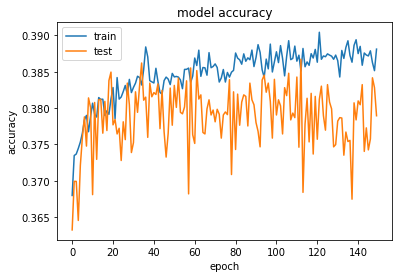

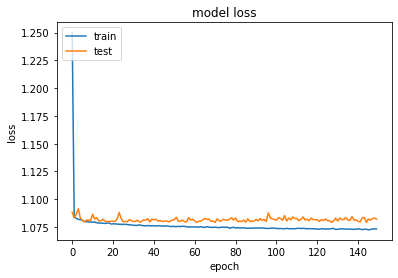

In [67]:
# summarize history for accuracy
plt.plot(history_run.history['accuracy'])
plt.plot(history_run.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_run.history['loss'])
plt.plot(history_run.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#test_loss, test_acc = model_run.evaluate(X_run_test, y_run_test)
#print('Test accuracy:', test_acc)

In [75]:
model_pass = keras.Sequential([
    keras.layers.Flatten(input_shape=(22,)),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(100, kernel_regularizer=l2(0.1), activation=tf.nn.relu),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(6, activation=tf.nn.softmax),
])

adam = optimizers.Adam(lr = 0.005)

model_pass.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_pass = model_pass.fit(X_pass_train, y_pass_train, epochs = 100, batch_size = 128, 
    validation_data = (X_pass_test, y_pass_test))

test_loss, test_acc = model_pass.evaluate(X_pass_test, y_pass_test)
print('Run Test accuracy:', test_acc)

Epoch 1/100
799/799 [==============================] - 1s 1ms/step - loss: 2.1729 - accuracy: 0.3182 - val_loss: 1.4601 - val_accuracy: 0.3354
Epoch 2/100
799/799 [==============================] - 1s 1ms/step - loss: 1.4533 - accuracy: 0.3310 - val_loss: 1.4273 - val_accuracy: 0.3352
Epoch 3/100
799/799 [==============================] - 1s 1ms/step - loss: 1.4283 - accuracy: 0.3310 - val_loss: 1.4176 - val_accuracy: 0.3345
Epoch 4/100
799/799 [==============================] - 1s 1ms/step - loss: 1.4243 - accuracy: 0.3301 - val_loss: 1.4168 - val_accuracy: 0.3334
Epoch 5/100
799/799 [==============================] - 1s 1ms/step - loss: 1.4160 - accuracy: 0.3320 - val_loss: 1.4085 - val_accuracy: 0.3352
Epoch 6/100
799/799 [==============================] - 1s 1ms/step - loss: 1.4144 - accuracy: 0.3310 - val_loss: 1.4178 - val_accuracy: 0.3358
Epoch 7/100
799/799 [==============================] - 1s 1ms/step - loss: 1.4127 - accuracy: 0.3301 - val_loss: 1.4076 - val_accuracy: 0.3355

Epoch 58/100
799/799 [==============================] - 1s 1ms/step - loss: 1.3945 - accuracy: 0.3338 - val_loss: 1.3927 - val_accuracy: 0.3374
Epoch 59/100
799/799 [==============================] - 1s 1ms/step - loss: 1.3943 - accuracy: 0.3352 - val_loss: 1.3988 - val_accuracy: 0.3372
Epoch 60/100
799/799 [==============================] - 1s 1ms/step - loss: 1.3958 - accuracy: 0.3344 - val_loss: 1.3906 - val_accuracy: 0.3382
Epoch 61/100
799/799 [==============================] - 1s 1ms/step - loss: 1.3976 - accuracy: 0.3349 - val_loss: 1.3961 - val_accuracy: 0.3367
Epoch 62/100
799/799 [==============================] - 1s 1ms/step - loss: 1.3967 - accuracy: 0.3354 - val_loss: 1.3927 - val_accuracy: 0.3382
Epoch 63/100
799/799 [==============================] - 1s 1ms/step - loss: 1.3936 - accuracy: 0.3364 - val_loss: 1.3946 - val_accuracy: 0.3373
Epoch 64/100
799/799 [==============================] - 1s 1ms/step - loss: 1.3942 - accuracy: 0.3321 - val_loss: 1.3973 - val_accuracy:

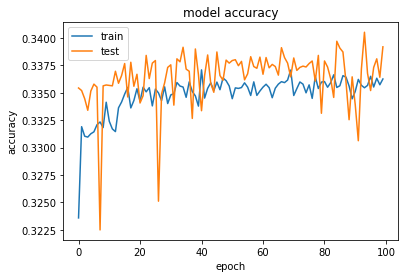

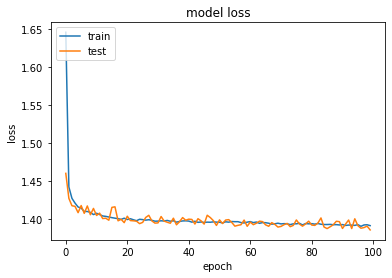

In [76]:
# summarize history for accuracy
plt.plot(history_pass.history['accuracy'])
plt.plot(history_pass.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_pass.history['loss'])
plt.plot(history_pass.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
test_loss, test_acc = model_pass.evaluate(X_pass_test, y_pass_test)
print('Pass Test accuracy:', test_acc)